# Overview
This notebook applies some basic signal processing techniques to the bird sounds dataset for classification. 

## Extract
- Choose a cutoff minimum duration $s$. This will be the common duration for all the samples 
- Extract the signal and the sample rate for each sample
- For now just truncate to the middle $s$ seconds for each sample
- Resample to a common rate
- Save the signals and the labels to a dataset

## Transform
- Apply framing and windowing
- Apply the DTFT to produce the spectrogram
- Design a noise filter
- Normalize the spectrograms

## Train 
- Use a Tensorflow dataset to flow from the persisted dataset and apply the transformations
- Train a CNN model

# Imports

In [2]:
import librosa
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import tensorflow as tf
import h5py
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
import math
from scipy.io.wavfile import write

2024-11-20 03:49:26.131904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732074566.154620    1124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732074566.161269    1124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 03:49:26.186023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Make sure GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Exploratory Data Analysis
Here we will explore some basic properties of the dataset and choose a value for $s$ that makes sense based on the data.

In [4]:
metadata = pd.read_csv('/data/recordings.csv')
metadata.head()

,id,gen,sp,ssp,group,en,rec,cnt,loc,lat,...,bird-seen,animal-seen,playback-used,temp,regnr,auto,dvc,mic,smp,label
0,936105,Branta,bernicla,NaN,birds,Brant Goose,Arjun Dutta,United Kingdom,"Great Britain (near Wallington), Greater Lond...",51.3532,...,no,no,no,NaN,NaN,no,Tascam DR-05x,NaN,44100,goose
1,934302,Branta,bernicla,NaN,birds,Brant Goose,Mats Olsson,Sweden,"Dalgången 23, Karlshamn, Blekinge län",NaN,...,no,no,no,NaN,NaN,no,Wildlife Acoustics,NaN,24000,goose
2,906056,Branta,bernicla,NaN,birds,Brant Goose,Juha Saari,Finland,"Pihlajamäki, Helsinki, Uusimaa",60.2357,...,no,no,no,NaN,NaN,yes,NaN,Telinga PRO-X,44100,goose
3,898133,Branta,bernicla,NaN,birds,Brant Goose,Paul Kelly,Ireland,"Tacumshin Lake (East End), County Wexford",52.1963,...,no,no,no,NaN,NaN,yes,SM4,SM4,44100,goose
4,882013,Branta,bernicla,NaN,birds,Brant Goose,Jean COURTIN,France,"Arrondissement de Vannes (near Sérent), Morbi...",47.7981,...,yes,yes,no,NaN,NaN,yes,NaN,NaN,44100,goose


In [5]:
# Extract timestamps
metadata['length'] = metadata['length'].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

# Create dictionary of id to label
label_dict = dict(zip(metadata['id'], metadata['label']))

In [6]:
metadata['length'].describe()

count    7006.000000
mean       42.353697
std        84.070134
min         0.000000
25%        10.000000
50%        21.000000
75%        45.000000
max      1800.000000
Name: length, dtype: float64

In [7]:
metadata[metadata['length'] > 10]['label'].value_counts()

label
hawk     2044
heron    1664
goose    1455
Name: count, dtype: int64

In [8]:
def plot_signal(signal, fs, title):
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(signal, sr=fs)
    plt.title(title)

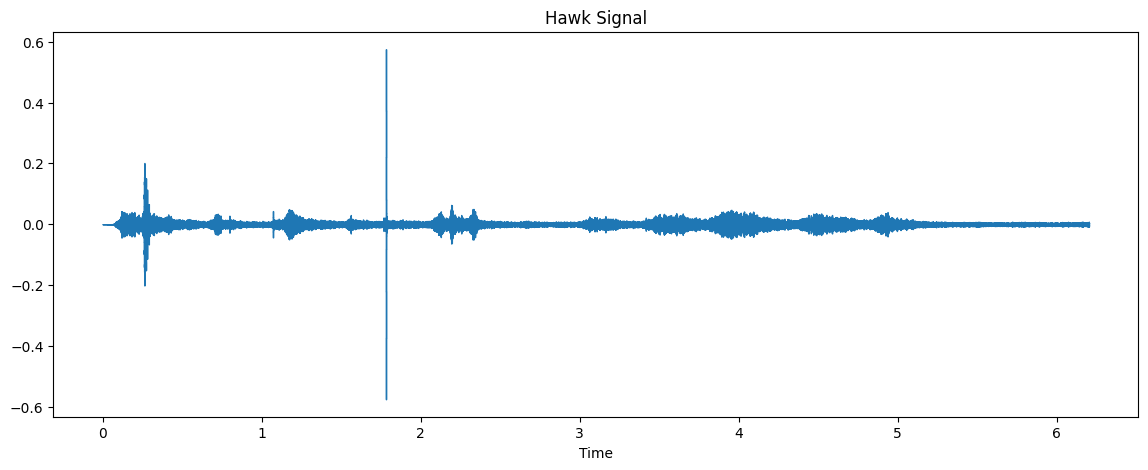

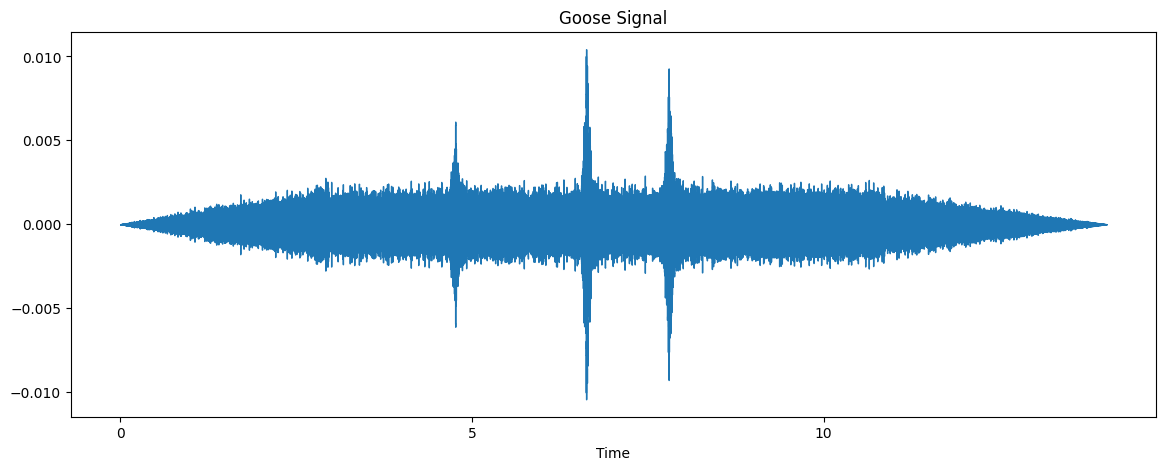

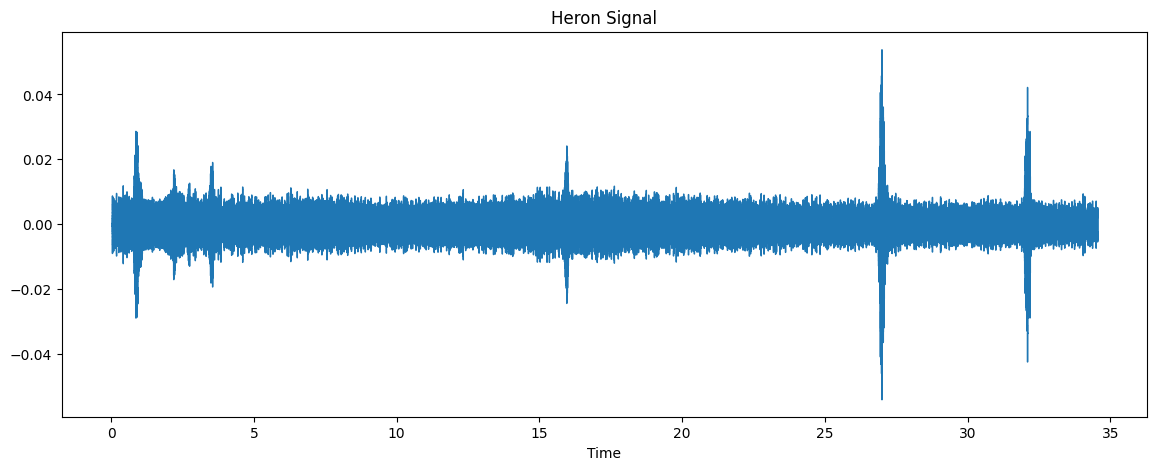

In [12]:
# Load signal and sample rate
hawk_signal, hawk_fs = librosa.load('/data/recordings/hawk_211230.mp3', sr=None)
goose_signal, goose_fs = librosa.load('/data/recordings/goose_678800.mp3', sr=None)
heron_signal, heron_fs = librosa.load('/data/recordings/heron_268502.mp3', sr=None)

# Plot signal
plot_signal(hawk_signal, hawk_fs, 'Hawk Signal')
plot_signal(goose_signal, goose_fs, 'Goose Signal')
plot_signal(heron_signal, heron_fs, 'Heron Signal')

# Extract
Here we will:
- Load the data using `librosa`
- Truncate to extract the middle $s$ seconds
- Resample to a common sample rate
- Save the signals and labels to a file

In [17]:
def extract_middle(signal, fs, duration_seconds=10):
    duration_samples = duration_seconds * fs
    signal_length = len(signal)
    start = (signal_length - duration_samples) // 2
    end = start + duration_samples
    return signal[start:end]

def load_batch(batch, duration_seconds=10, target_fs=16000):
    signals = []
    labels = []
    ids = []
    for i, file in enumerate(batch):
        # Check that file exists
        if not os.path.exists(f'/data/recordings/{file}'):
            print(f'Skipping {file} due to missing file')
            continue
        signal, fs = librosa.load(f'/data/recordings/{file}', sr=None)
        signal = extract_middle(signal, fs, duration_seconds)
        if len(signal) != duration_seconds * fs:
            print(f'Skipping {file} due to incorrect duration')
            continue
        signal = librosa.resample(signal, orig_sr=fs, target_sr=target_fs)
        signals.append(signal)
        file_name = file.split('_')
        labels.append(file_name[0])
        ids.append(int(file_name[1].split('.')[0]))
    return np.array(signals), np.array(ids), np.array(labels)

def save_batch(batch, save_path, dataset_name='signals'):
    with h5py.File(save_path, 'a') as f:
        if dataset_name in f:
            dataset = f[dataset_name]
            dataset.resize(dataset.shape[0] + batch.shape[0], axis=0)
            dataset[-batch.shape[0]:] = batch
        else:
            maxshape = (None,) + batch.shape[1:]
            f.create_dataset(dataset_name, data=batch, maxshape=maxshape, chunks=True)

def get_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

def extract_signals(file_list, save_path, ohe, duration_seconds=10, batch_size=32, target_fs=16000):
    for i, batch_files in enumerate(get_batches(file_list, batch_size)):
        signals, ids, labels = load_batch(batch_files, duration_seconds, target_fs)
        labels = ohe.transform(labels.reshape(-1, 1)).toarray()
        save_batch(signals, save_path, f'signals_{duration_seconds}s_{target_fs}hz')
        save_batch(labels, save_path, 'labels')
        save_batch(ids, save_path, 'ids')
        print(f'Saved {len(batch_files)} signals for batch {i}')

In [14]:
signals, ids, labels = load_batch(['hawk_531031.mp3'], duration_seconds=10, target_fs=16000)

In [75]:
signals[0]
write('/data/test.wav', 16000, signals[0])

In [63]:
signal, fs = librosa.load(f'/data/recordings/hawk_531031.mp3', sr=None)
middle_signal = extract_middle(signal, fs, 10)
write('/data/test.wav', fs, middle_signal)

In [18]:
metadata['file_path'] = metadata[['id', 'label']].apply(lambda x: f'{x[1]}_{x[0]}.mp3', axis=1)
files = metadata[metadata['length'] > 10]['file_path'].values
len(files)

/tmp/ipykernel_1124/2003793498.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metadata['file_path'] = metadata[['id', 'label']].apply(lambda x: f'{x[1]}_{x[0]}.mp3', axis=1)


5163

In [ ]:
ohe = OneHotEncoder().fit(np.array(['hawk', 'heron', 'goose']).reshape(-1, 1))
# extract_signals(files, '/data/bird_sounds.h5', ohe, duration_seconds=10, batch_size=64, target_fs=16000)

Saved 64 signals for batch 0
Saved 64 signals for batch 1


Note: Illegal Audio-MPEG-Header 0x616e6420 at offset 337024.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 2
Saved 64 signals for batch 3
Saved 64 signals for batch 4
Saved 64 signals for batch 5


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 928831.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 6
Saved 64 signals for batch 7
Saved 64 signals for batch 8


Note: Illegal Audio-MPEG-Header 0x65617220 at offset 569152.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 9
Skipping goose_209702.mp3 due to incorrect duration


[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Saved 64 signals for batch 10


Note: Illegal Audio-MPEG-Header 0x65617220 at offset 494848.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 11


[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Skipping goose_204697.mp3 due to incorrect duration


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 910649.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 12


[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Saved 64 signals for batch 13
Saved 64 signals for batch 14
Saved 64 signals for batch 15


Note: Illegal Audio-MPEG-Header 0x61746964 at offset 228123.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 16
Saved 64 signals for batch 17
Saved 64 signals for batch 18
Saved 64 signals for batch 19
Saved 64 signals for batch 20
Saved 64 signals for batch 21
Saved 64 signals for batch 22
Saved 64 signals for batch 23
Saved 64 signals for batch 24
Saved 64 signals for batch 25
Saved 64 signals for batch 26
Saved 64 signals for batch 27


Note: Illegal Audio-MPEG-Header 0x003c0200 at offset 224992.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Skipping heron_937061.mp3 due to incorrect duration
Saved 64 signals for batch 28
Saved 64 signals for batch 29
Saved 64 signals for batch 30
Saved 64 signals for batch 31
Saved 64 signals for batch 32
Saved 64 signals for batch 33


Note: Illegal Audio-MPEG-Header 0x72646561 at offset 590075.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 34


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 849628.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Skipping heron_935496.mp3 due to incorrect duration
Saved 64 signals for batch 35
Saved 64 signals for batch 36
Saved 64 signals for batch 37
Saved 64 signals for batch 38
Saved 64 signals for batch 39
Saved 64 signals for batch 40


Note: Illegal Audio-MPEG-Header 0x2f2f2037 at offset 527590.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Skipping heron_416455.mp3 due to missing file
Saved 64 signals for batch 41
Saved 64 signals for batch 42


Note: Illegal Audio-MPEG-Header 0x64656120 at offset 249439.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 43
Saved 64 signals for batch 44


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 496243.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 45
Saved 64 signals for batch 46
Saved 64 signals for batch 47
Skipping heron_937068.mp3 due to incorrect duration
Skipping heron_937064.mp3 due to incorrect duration
Skipping heron_935502.mp3 due to incorrect duration


Note: Illegal Audio-MPEG-Header 0x292c2042 at offset 893096.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 48


Note: Illegal Audio-MPEG-Header 0x42757465 at offset 356854.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x54004a75 at offset 106734.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x52544953 at offset 747483.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 49


Note: Illegal Audio-MPEG-Header 0x53616e74 at offset 379633.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x00415045 at offset 211403.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 50
Skipping hawk_116586.mp3 due to incorrect duration


Note: Illegal Audio-MPEG-Header 0xb56b3288 at offset 14243.
Note: Trying to resync...
Note: Skipped 137 bytes in input.
Note: Illegal Audio-MPEG-Header 0x20646520 at offset 701879.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x000000a0 at offset 327808.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 51
Saved 64 signals for batch 52


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 213912.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x61676961 at offset 444207.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 53


Note: Illegal Audio-MPEG-Header 0x09000000 at offset 30736.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 54


Note: Illegal Audio-MPEG-Header 0x2f203330 at offset 609719.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 398649.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 55
Saved 64 signals for batch 56


Note: Illegal Audio-MPEG-Header 0x65642053 at offset 515679.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x00004152 at offset 515679.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 57


Note: Illegal Audio-MPEG-Header 0x42757465 at offset 756841.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 58


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 320492.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x32303136 at offset 4764443.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 59


Note: Illegal Audio-MPEG-Header 0x65726368 at offset 385484.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x50455441 at offset 1525049.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 60
Saved 64 signals for batch 61
Saved 64 signals for batch 62
Saved 64 signals for batch 63


Note: Illegal Audio-MPEG-Header 0x6e736973 at offset 752243.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Saved 64 signals for batch 64
Saved 64 signals for batch 65
Saved 64 signals for batch 66
Saved 64 signals for batch 67
Saved 64 signals for batch 68
Saved 64 signals for batch 69


Note: Illegal Audio-MPEG-Header 0x7c25f0d8 at offset 384437.
Note: Trying to resync...
Note: Skipped 5 bytes in input.


Saved 64 signals for batch 70


Note: Illegal Audio-MPEG-Header 0x50455441 at offset 3975753.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Skipping hawk_526851.mp3 due to incorrect duration
Saved 64 signals for batch 71
Saved 64 signals for batch 72
Saved 64 signals for batch 73
Saved 64 signals for batch 74
Saved 64 signals for batch 75
Saved 64 signals for batch 76
Saved 64 signals for batch 77
Saved 64 signals for batch 78
Saved 64 signals for batch 79
Saved 43 signals for batch 80


In [34]:
# Load a single signal from the dataset
def load_dataset(file_path, indices, duration_seconds=10, target_fs=16000):
    with h5py.File(file_path, 'r') as f:
        signals = f[f'signals_{duration_seconds}s_{target_fs}hz'][indices]
        labels = f['labels'][indices]
        ids = f['ids'][indices]
    return signals, labels, ids

In [35]:
signals, labels, ids = load_dataset('/data/bird_sounds.h5', slice(0, 20))

In [36]:
# Listen to the first signal
write('/data/test.wav', 16000, signals[0, :])

## Transform
Here we will build a TensorFlow dataset that reads from the saved file in batches and applies the following transformations:
- Framing
- Windowing (using a Hamming function)
- FFT (real-valued) to produce the spectrogram
- Take the log magnitude of the spectrum
- Normalize

In [37]:
def load_dataset(file_path, dataset_name):
    with h5py.File(file_path, 'r') as f:
        data = f[dataset_name]
        for i in range(len(data)):
            yield data[i]

In [38]:
signal_it = load_dataset('/data/bird_sounds.h5', 'signals_10s_16000hz')
signal = next(signal_it)

In [39]:
write('/data/randobird.wav', 16000, signal)

In [40]:
frame_size = 1024
frame_step = 512 # 50% overlap
frames = tf.signal.frame([signal], frame_length=frame_size, frame_step=frame_step)
window = tf.signal.hamming_window(frame_size)
windowed_frames = frames * window
spectrogram = tf.abs(tf.signal.rfft(windowed_frames))
log_spectrogram = tf.math.log(spectrogram + 1e-6)

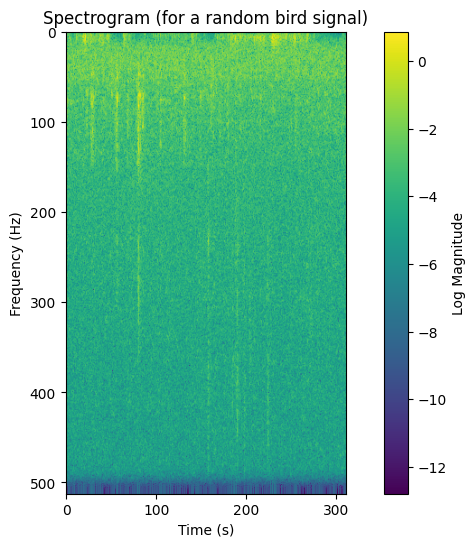

In [41]:
plt.figure(figsize=(10, 6))
plt.imshow(tf.transpose(log_spectrogram))
plt.colorbar(label='Log Magnitude')
plt.title("Spectrogram (for a random bird signal)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

In [50]:
def build_signal_dataset(filepath, dataset_name, batch_size, sample_rate = 16000, duration_seconds = 10, frame_size = 1024, step_size = 512):
    signal_dataset = tf.data.Dataset.from_generator(
        lambda: load_dataset(filepath, dataset_name),
        output_signature=tf.TensorSpec(shape=(sample_rate * duration_seconds,), dtype=tf.float32)
    )

    label_dataset = tf.data.Dataset.from_generator(
        lambda: load_dataset(filepath, 'labels'),
        output_signature=tf.TensorSpec(shape=(3,), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.zip((signal_dataset, label_dataset))

    window = tf.signal.hamming_window(frame_size)
    
    # Framing
    dataset = dataset.map(
        lambda signals, labels: (tf.signal.frame(signals, frame_size, step_size, axis=0), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Windowing
    dataset = dataset.map(
        lambda signals, labels: (signals * window, labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Real-valued Fourier Transform
    dataset = dataset.map(
        lambda signals, labels: (tf.signal.rfft(signals), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Log-magnitude
    dataset = dataset.map(
        lambda signals, labels: (tf.math.log(tf.abs(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Normalization
    dataset = dataset.map(
        lambda signals, labels: (tf.math.divide(signals, tf.reduce_max(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size)
    return dataset

In [43]:
def compute_input_size(sample_rate, duration_seconds, frame_size, step_size):
    signal_length = sample_rate * duration_seconds
    
    # Compute the number of frames
    num_frames = math.floor((signal_length - frame_size) / step_size) + 1
    
    # Compute the number of frequency bins
    frequency_bins = frame_size // 2 + 1
    
    return num_frames, frequency_bins

In [61]:
dataset = build_signal_dataset('/data/bird_sounds.h5', 'signals_10s_16000hz', 32, duration_seconds=10, frame_size=1024, step_size=512)

# Train
Finally, build a CNN model to train on the normalized log spectrograms from the dataset.

In [44]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    return model

In [45]:
sample_rate = 16000
duration_seconds = 10
frame_size = 1024
step_size = 512
batch_size = 32

In [62]:
dataset = build_signal_dataset('/data/bird_sounds.h5', 'signals_10s_16000hz', batch_size, duration_seconds=duration_seconds, frame_size=frame_size, step_size=step_size)
num_frames, frequency_bins = compute_input_size(sample_rate, duration_seconds, frame_size, step_size)
model = build_model((num_frames, frequency_bins, 1), 3)

In [63]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 311, 513, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 155, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 155, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 155, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 77, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 77, 128, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 77, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 38, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 38, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 311296)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    39,846,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,939,971 (152.36 MB)

 Trainable params: 39,939,523 (152.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [64]:
model.fit(dataset, epochs=10)

Epoch 1/10


I0000 00:00:1732116306.207370    4052 service.cc:148] XLA service 0x789b88018050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732116306.207412    4052 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-11-20 15:25:06.293052: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732116306.627447    4052 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-20 15:25:08.273178: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,155,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,155,256]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_conf

    161/Unknown 38s 144ms/step - accuracy: 0.2726 - loss: nan

2024-11-20 15:25:42.175442: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,64,155,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,155,256]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2024-11-20 15:25:42.234671: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,128,77,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,77,128]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForw

162/162 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.2732 - loss: nan
Epoch 2/10


2024-11-20 15:25:44.769855: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3037784339397220307
2024-11-20 15:25:44.769940: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 2756481887349555716
/home/scientist/miniconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


 13/162 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.0000e+00 - loss: nan

KeyboardInterrupt: 